In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Reshape, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import cv2
import glob
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# label dataframe

In [2]:
directory = 'final_data/train_dark/labels'
raw_labels = []

for filename in tqdm(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        #print(filename[:-4])
        o = open(f, "r")
        x = o.read().split()
        #print(x)
        raw_label_row = [filename[:-4]+'.jpeg']
        raw_label_row = raw_label_row + x
        raw_labels.append(raw_label_row)

#print(raw_labels)
df = pd.DataFrame(raw_labels, columns =['ImageID', 'LabelName', 'xcenter','ycenter','bbx_width','bbx_height'])
print(df)

100%|████████████████████████████████████| 7500/7500 [00:00<00:00, 34842.74it/s]

                                        ImageID LabelName  \
0     aa1e103f-8785-48b8-940c-134ec71aa324.jpeg         3   
1     019b751c-eee4-479d-92a4-7e18d455b473.jpeg         1   
2     b7f6aadc-90af-4289-b303-58f7648c15d8.jpeg         1   
3     6e7c132c-3092-42a5-8329-4e06101fd796.jpeg         4   
4     f69a5e6b-8fc9-4efa-a3d0-b3bc693217fb.jpeg         1   
...                                         ...       ...   
7495  a597d508-93e1-4f49-a47e-4ee6c2e044ca.jpeg         1   
7496  b0dc45a9-864d-4c80-9fa0-38d26f60a849.jpeg         3   
7497  47b61d9d-4efa-4192-8a12-7ac83b5428fc.jpeg         3   
7498  ca274f19-91b2-4a10-bc7e-55fe5f7c50c3.jpeg         3   
7499  a8c9950d-3d4a-415b-90aa-38c2f273fe4d.jpeg         3   

                  xcenter              ycenter            bbx_width  \
0             0.490234375          0.673828125  0.21223958333333334   
1     0.48117690058479534   0.4862253289473684   0.2364766081871345   
2      0.5032299741602068             0.453125   0.370

In [3]:
df.head()

ImageID LabelName              xcenter  \
0  aa1e103f-8785-48b8-940c-134ec71aa324.jpeg         3          0.490234375   
1  019b751c-eee4-479d-92a4-7e18d455b473.jpeg         1  0.48117690058479534   
2  b7f6aadc-90af-4289-b303-58f7648c15d8.jpeg         1   0.5032299741602068   
3  6e7c132c-3092-42a5-8329-4e06101fd796.jpeg         4   0.5804973821989529   
4  f69a5e6b-8fc9-4efa-a3d0-b3bc693217fb.jpeg         1               0.4115   

              ycenter            bbx_width           bbx_height  
0         0.673828125  0.21223958333333334          0.150390625  
1  0.4862253289473684   0.2364766081871345   0.1689967105263158  
2            0.453125   0.3708010335917313  0.22747093023255813  
3          0.41015625  0.20026178010471204          0.181640625  
4  0.4638333333333333               0.1605   0.2703333333333333

# show an image

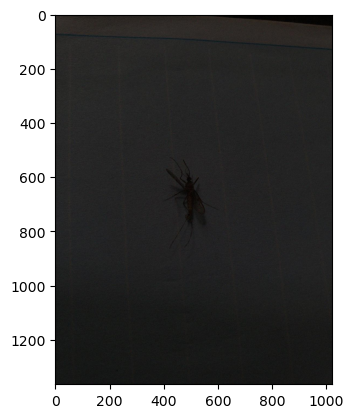

In [4]:
# checking a random image
train_dir = 'final_data/train_dark/images'
image_id = df.loc[510, "ImageID"]
image_path = train_dir+"/"+image_id
image = plt.imread(image_path)
plt.imshow(image)

# model class

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU, Reshape, Concatenate, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

class SSDModel(Model):
    def __init__(self, num_classes):
        super(SSDModel, self).__init__()
        self.num_classes = num_classes
        
        # Feature extractor backbone (MobileNetV2)
        self.backbone = MobileNetV2(include_top=False, input_shape=(320, 320, 3), weights='imagenet', pooling='avg')
        self.backbone.trainable = False
        
        # Additional dense layers
        self.dense1 = Dense(32, activation='sigmoid', name='dense1')
        self.dense2 = Dense(32, activation='sigmoid', name='dense2')
        self.dense3 = Dense(32, activation='sigmoid', name='dense3')
        
        # Classifier and regressor layers
        self.classifier = Dense(num_classes, activation='softmax')
        self.regressor = Dense(4, activation='sigmoid')  # Predicting only one box

    def call(self, inputs):
        # Feature extraction
        x = self.backbone(inputs)
        
        # Additional dense layers
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        # Classifier and regressor predictions
        class_preds = self.classifier(x)
        box_preds = self.regressor(x)
        
        # Concatenate predictions
        return Concatenate(axis=-1)([class_preds, box_preds])


In [6]:
# Create an instance of the model
ssd_model = SSDModel(num_classes=6)  # 6 classes + 1 background

# data generator for batch training

In [7]:
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os

from tensorflow.keras.utils import to_categorical

class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, dim=(320, 320), n_channels=3, n_classes=6, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.image_paths = image_paths
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        X, y = self.__data_generation(image_paths_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp):
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size, self.n_classes + 4), dtype=np.float32)

        for i, image_path in enumerate(image_paths_temp):
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to load image at {image_path}")
                continue
            image = cv2.resize(image, self.dim)

            # Apply CLAHE to RGB channels
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            for channel in range(3):
                image[:, :, channel] = clahe.apply(image[:, :, channel])

            # Apply gamma correction
            gamma = 0.6  # Adjust gamma to better preserve color
            image = ((image / 255.0) ** gamma) * 255.0
            image = np.clip(image, 0, 255)  # Ensure the values are within the byte range

            image = image / 255.0  # Normalize the image
            X[i,] = image

            label_file = image_path.replace('/images/', '/labels/').replace('.jpeg', '.txt')
            if os.path.isfile(label_file):
                with open(label_file, 'r') as file:
                    line = file.readline()
                    parts = line.split()
                    class_id = int(parts[0])
                    coords = list(map(float, parts[1:]))

                y[i, :self.n_classes] = to_categorical(class_id, num_classes=self.n_classes)
                y[i, self.n_classes:] = coords
            else:
                print(f"Label file not found for image: {image_path}")

        return X, y


# create opt

In [8]:
import tensorflow as tf

def smooth_l1_loss(y_true, y_pred):
    l1_loss = tf.losses.Huber(reduction=tf.losses.Reduction.NONE)
    # Apply ReLU activation to ensure bounding box values are positive
    return tf.nn.sigmoid(tf.reduce_mean(l1_loss(y_true, y_pred), axis=-1))

def ssd_loss(num_classes):
    def ssd_loss_fn(y_true, y_pred):
        # Split the inputs into class and box predictions
        y_true_cls = y_true[:, :num_classes]  # First part are class labels
        y_true_box = y_true[:, num_classes:]  # Last four are bounding box coords
        y_pred_cls = y_pred[:, :num_classes]  # Same split for predictions
        y_pred_box = y_pred[:, num_classes:]

        # Classification loss
        cls_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true_cls, logits=y_pred_cls)
        cls_loss = tf.reduce_mean(cls_loss)  # Average over the batch

        # Localization loss using smooth L1 loss with positive bounding box values
        loc_loss = smooth_l1_loss(y_true_box, y_pred_box)
        loc_loss = tf.reduce_mean(loc_loss)  # Average over the batch

        # Combine them
        total_loss = cls_loss + loc_loss
        return total_loss

    return ssd_loss_fn

# Example setup
num_classes = 6  # Including background class
ssd_model.compile(optimizer='adam', loss=ssd_loss(num_classes), metrics=['accuracy'])

# train

In [9]:
import glob

# Get all image paths
image_paths_train = glob.glob('final_data/train_dark/images/*.jpeg')
# Assuming label files match the image files' names but are located in the labels directory
labels_train = [p.replace('/images/', '/labels/').replace('.jpeg', '.txt') for p in image_paths_train]

# Now image_paths_train and labels_train should be lists of file paths
print("Number of images:", len(image_paths_train))
print("Number of labels:", len(labels_train))


Number of images: 7500
Number of labels: 7500


In [10]:
# Test loading a single image
test_image_path = image_paths_train[0] if image_paths_train else ""
test_image = cv2.imread(test_image_path)
if test_image is not None:
    print("Image loaded successfully!")
else:
    print("Failed to load image at:", test_image_path)

Image loaded successfully!


In [11]:
# Assuming `image_paths` and `labels` are lists containing your data
train_generator = DataGenerator(image_paths=image_paths_train, labels=labels_train, batch_size=16, n_classes=6)


# checking train loader

Batch images shape: (16, 320, 320, 3)
Batch labels shape: (16, 10)


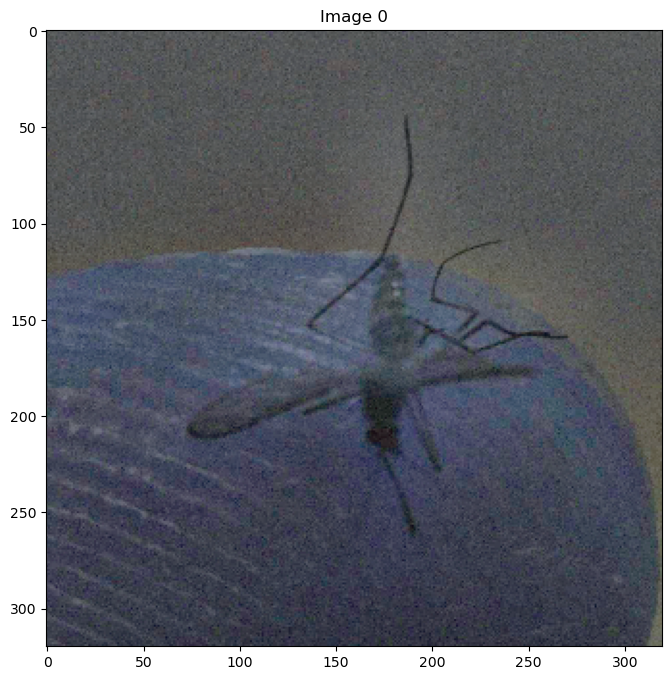

Labels for image 0: [0.         0.         0.         1.         0.         0.
 0.5964912  0.49243188 0.5219298  0.7608476 ]


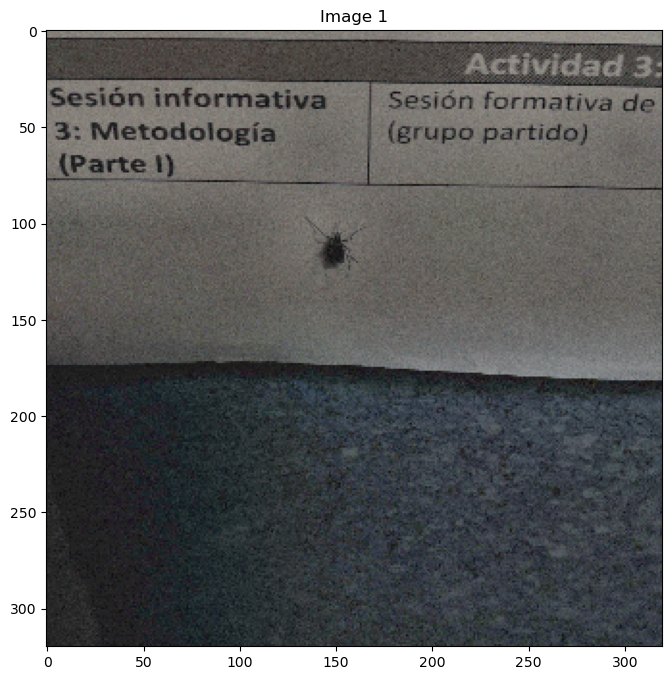

Labels for image 1: [0.         1.         0.         0.         0.         0.
 0.4651163  0.35222867 0.12015504 0.11627907]


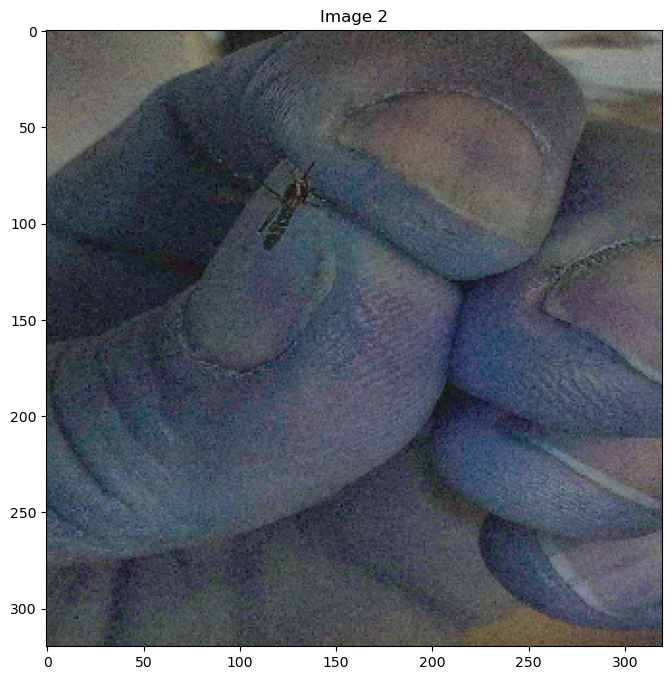

Labels for image 2: [0.         1.         0.         0.         0.         0.
 0.36944443 0.2775     0.21444444 0.1675    ]


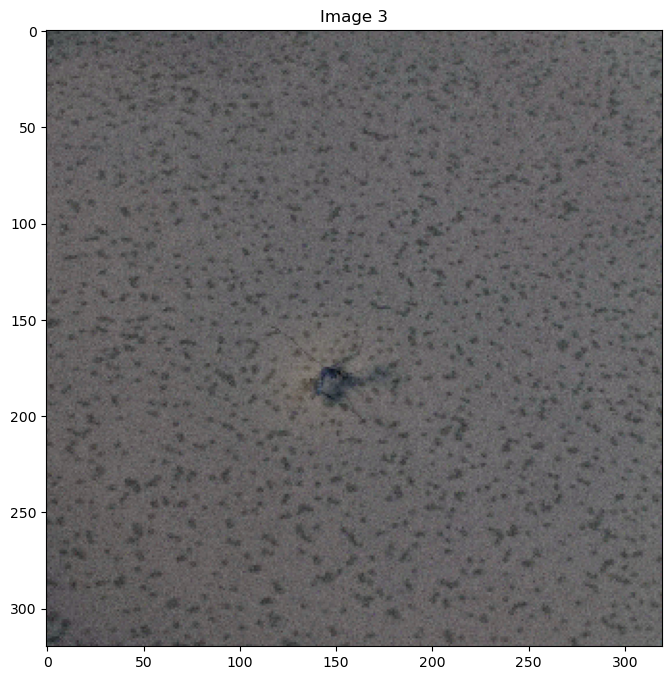

Labels for image 3: [0.         0.         0.         1.         0.         0.
 0.43833333 0.554375   0.194      0.16525   ]


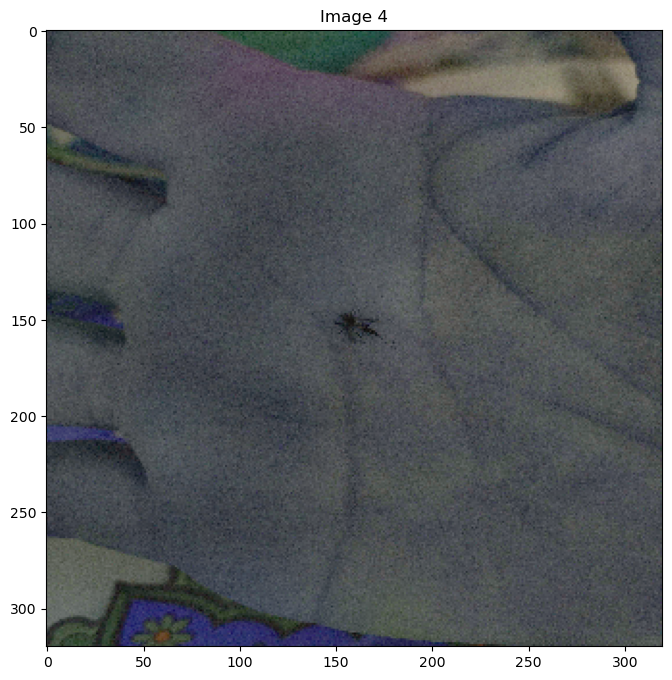

Labels for image 4: [0.         1.         0.         0.         0.         0.
 0.51533335 0.473625   0.14333333 0.12275   ]


In [12]:
# Fetch one batch of data
batch_images, batch_labels = train_generator.__getitem__(0)

# Alternatively, use the next function to get the first batch
# batch_images, batch_labels = next(iter(train_generator))

# Verify the shape of the outputs
print(f'Batch images shape: {batch_images.shape}')  # Expected to be (batch_size, 320, 320, 3)
print(f'Batch labels shape: {batch_labels.shape}')  # Expected to be (batch_size, 1, num_classes+4)

# Check a subset of images and their corresponding labels to ensure they are loaded and processed correctly
import matplotlib.pyplot as plt

# Visualize the first few images
for i in range(5):  # Display the first 5 images of the batch
    plt.figure(figsize=(8, 8))
    plt.imshow(batch_images[i])
    plt.title(f'Image {i}')
    plt.show()

    # Assuming that the labels are in the form [class, x_center, y_center, width, height]
    print(f'Labels for image {i}: {batch_labels[i]}')

In [13]:
# Try a simple forward pass
test_input = tf.random.normal([1, 320, 320, 3])
test_output = ssd_model(test_input)
print(test_output.shape)  # Check output shape

(1, 10)


In [14]:
# Fit model
history = ssd_model.fit(train_generator, epochs=20, verbose=1)

Epoch 1/20
468/468 [==============================] - 159s 325ms/step - loss: 2.0349 - accuracy: 0.4722
Epoch 2/20
468/468 [==============================] - 154s 328ms/step - loss: 1.9125 - accuracy: 0.6364
Epoch 3/20
468/468 [==============================] - 153s 328ms/step - loss: 1.8946 - accuracy: 0.6489
Epoch 4/20
468/468 [==============================] - 153s 328ms/step - loss: 1.8815 - accuracy: 0.6624
Epoch 5/20
468/468 [==============================] - 153s 327ms/step - loss: 1.8774 - accuracy: 0.6660
Epoch 6/20
468/468 [==============================] - 154s 330ms/step - loss: 1.8665 - accuracy: 0.6786
Epoch 7/20
468/468 [==============================] - 154s 329ms/step - loss: 1.8668 - accuracy: 0.6778
Epoch 8/20
468/468 [==============================] - 156s 333ms/step - loss: 1.8545 - accuracy: 0.6908
Epoch 9/20
468/468 [==============================] - 155s 332ms/step - loss: 1.8543 - accuracy: 0.6914
Epoch 10/20
468/468 [==============================] - 154s 328m

In [16]:
# Save the entire model in the TensorFlow SavedModel format
ssd_model.save('ssd_model_full')

INFO:tensorflow:Assets written to: ssd_model_full/assets


INFO:tensorflow:Assets written to: ssd_model_full/assets


In [17]:
import os
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array

# Define the directory containing test images
test_dir = "final_data/test_dark/images"
image_files = os.listdir(test_dir)

# Make predictions for each test image
predictions = []
for image_file in image_files:
    # Load and preprocess the image
    image_path = os.path.join(test_dir, image_file)
    img = load_img(image_path, target_size=(320, 320))
    img_array = img_to_array(img)
    # Perform any necessary preprocessing here if not done during training
    
    # Make prediction using your model (assuming model is named ssd_model)
    prediction = ssd_model.predict(img_array.reshape(1, 320, 320, 3)).flatten()
    predictions.append(prediction)

# Define the class map
class_map = {
    0: "aegypti",
    1: "albopictus",
    2: "anopheles",
    3: "culex",
    4: "culiseta",
    5: "japonicus/koreicus"
}

# Create a DataFrame to store the submission data
submission_data = {
    "id": range(len(image_files)),
    "ImageID": image_files,
    "LabelName": [class_map[prediction[:6].argmax()] for prediction in predictions],
    "Conf": [prediction[:6].max() for prediction in predictions],
    "xcenter": [prediction[6] for prediction in predictions],
    "ycenter": [prediction[7] for prediction in predictions],
    "bbx_width": [prediction[8] for prediction in predictions],
    "bbx_height": [prediction[9] for prediction in predictions]
}

# Create a DataFrame
submission_df = pd.DataFrame(submission_data)

# Export to CSV
submission_df.to_csv("submission.csv", index=False)


1/1 [==============================] - 0s 18ms/step


In [18]:
ssd_model.summary()


Model: "ssd_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense1 (Dense)              multiple                  40992     
                                                                 
 dense2 (Dense)              multiple                  1056      
                                                                 
 dense3 (Dense)              multiple                  1056      
                                                                 
 dense (Dense)               multiple                  198       
                                                                 
 dense_1 (Dense)             multiple                  132       
                                                         

In [24]:
ssd_model.save_weights('mymodel.h5')

In [31]:
new_model = SSDModel(num_classes=6) 
new_model.build((None, 320,320,3))
new_model.load_weights('mymodel.h5')

In [33]:
import os
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array

# Define the directory containing test images
test_dir = "final_data/test_dark/images"
image_files = os.listdir(test_dir)

# Make predictions for each test image
predictions = []
for image_file in image_files:
    # Load and preprocess the image
    image_path = os.path.join(test_dir, image_file)
    img = load_img(image_path, target_size=(320, 320))
    img_array = img_to_array(img)
    # Perform any necessary preprocessing here if not done during training
    
    # Make prediction using your model (assuming model is named ssd_model)
    prediction = new_model.predict(img_array.reshape(1, 320, 320, 3)).flatten()
    predictions.append(prediction)

# Define the class map
class_map = {
    0: "aegypti",
    1: "albopictus",
    2: "anopheles",
    3: "culex",
    4: "culiseta",
    5: "japonicus/koreicus"
}

# Create a DataFrame to store the submission data
submission_data = {
    "id": range(len(image_files)),
    "ImageID": image_files,
    "LabelName": [class_map[prediction[:6].argmax()] for prediction in predictions],
    "Conf": [prediction[:6].max() for prediction in predictions],
    "xcenter": [prediction[6] for prediction in predictions],
    "ycenter": [prediction[7] for prediction in predictions],
    "bbx_width": [prediction[8] for prediction in predictions],
    "bbx_height": [prediction[9] for prediction in predictions]
}

# Create a DataFrame
submission_df = pd.DataFrame(submission_data)

# Export to CSV
submission_df.to_csv("submission_pretrained.csv", index=False)


1/1 [==============================] - 0s 27ms/step
